## Previsão Ibovespa
Esse notebook tem como objetivo realizar a previsão do índice IBovespa utilizando alguns modelos de Machine Learning. Esse projeto foi realizado como parte da Fase 2 da pós graduação em Data Analytics da POSTECH FIAP.

### 1. Entendimento do Negócio
O problema
Imagine que você foi escalado para um time de investimentos e precisará realizar um modelo preditivo com dados da IBOVESPA (Bolsa de valores) para criar uma série temporal e prever diariamente o fechamento da base.

Você precisará demonstrar para o time de investimentos:
1. O modelo com o storytelling, desde a captura do dado até a entrega do 
modelo;
2. Justificar a técnica utilizada;
3. Atingir uma acuracidade adequada (acima de 70%)

### 2. Entendimento dos Dados
Para isso, utilize a base de dados contida no site da Investing https://br.investing.com/indices/bovespa-historical-data) e selecione o período “diário”, com o intervalo de tempo que achar adequado. 

Testaremos alguns períodos Históricos para treinamento com uso de 180 dias anteriores para previsão. 

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from datetime import datetime


from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

In [19]:
url = 'https://raw.githubusercontent.com/Data-Analitycs-Pos-Tech-Fiap/Ibovespa-prev/refs/heads/main/datasets/Dados%20Hist%C3%B3ricos%20-%20Ibovespa%202000%20a%202025.csv'

dados = pd.read_csv(url, sep=',', encoding='utf-8')

dados.head(10)

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
0,03.01.2025,118.533,120.125,120.356,118.404,"9,80B","-1,33%"
1,02.01.2025,120.125,120.283,120.782,119.120,"9,37B","-0,13%"
2,30.12.2024,120.283,120.267,121.050,120.158,"8,90B","0,01%"
3,27.12.2024,120.269,121.078,121.609,120.252,"8,94B","-0,67%"
4,26.12.2024,121.078,120.767,121.612,120.428,"8,34B","0,26%"
5,23.12.2024,120.767,122.105,122.105,120.617,"9,95B","-1,09%"
6,20.12.2024,122.102,121.183,122.209,120.700,"18,13B","0,75%"
7,19.12.2024,121.188,120.768,121.770,120.768,"13,68B","0,34%"
8,18.12.2024,120.772,124.699,124.699,120.457,"19,74B","-3,15%"
9,17.12.2024,124.698,123.560,125.301,123.560,"17,56B","0,92%"


In [20]:
# compreendendo os tipos de dados e o shape da base
print(dados.info())
print('----------------------------------------------------')
print('TAMANHO DA BASE: ', dados.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4954 entries, 0 to 4953
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Data      4954 non-null   object 
 1   Último    4954 non-null   float64
 2   Abertura  4954 non-null   float64
 3   Máxima    4954 non-null   float64
 4   Mínima    4954 non-null   float64
 5   Vol.      4953 non-null   object 
 6   Var%      4954 non-null   object 
dtypes: float64(4), object(3)
memory usage: 271.1+ KB
None
----------------------------------------------------
TAMANHO DA BASE:  (4954, 7)


In [21]:
dados.columns

Index(['Data', 'Último', 'Abertura', 'Máxima', 'Mínima', 'Vol.', 'Var%'], dtype='object')

In [22]:
# Converter a coluna 'Data' para datetime
dados['Data'] = pd.to_datetime(dados['Data'], format='%d.%m.%Y', errors='coerce')

# Definir 'Data' como índice e ordenar
dados = dados.set_index('Data').sort_index()

# Reindexar com frequência diária
dados = dados.asfreq('D', method='ffill')

# Preencher valores NaN nas outras colunas
for column in dados.columns:
    dados[column] = dados[column].fillna(method='ffill')

# Resetar o índice
dados.reset_index(inplace=True)

# Verificar o resultado
print(dados.head(10))


        Data  Último  Abertura  Máxima  Mínima     Vol.    Var%
0 2005-01-04  24.848    25.722  25.873  24.791  146,14M  -3,40%
1 2005-01-05  24.692    24.859  25.001  24.523  127,42M  -0,63%
2 2005-01-06  24.367    24.695  24.808  24.250  151,17M  -1,32%
3 2005-01-07  24.747    24.376  24.874  24.376  104,96M   1,56%
4 2005-01-08  24.747    24.376  24.874  24.376  104,96M   1,56%
5 2005-01-09  24.747    24.376  24.874  24.376  104,96M   1,56%
6 2005-01-10  24.292    24.747  24.825  24.086  126,23M  -1,84%
7 2005-01-11  24.370    24.295  24.457  24.127  111,40M   0,32%
8 2005-01-12  24.510    24.370  24.560  23.983  107,12M   0,57%
9 2005-01-13  24.806    24.523  24.919  24.523   91,08M   1,21%


C:\Users\kelvyn.candido\AppData\Local\Temp\ipykernel_5184\1433539146.py:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  dados[column] = dados[column].fillna(method='ffill')


In [23]:
# incluindo coluna categórica
dados['unique_id'] = 'ibovespa'

In [24]:
# renomeando colunas
dados = dados.rename(columns={'Data': 'ds', 'Último': 'y'})
# selecionando colunas
dados = dados[['ds', 'y', 'unique_id']]
dados.head(10)

,ds,y,unique_id
0,2005-01-04,24.848,ibovespa
1,2005-01-05,24.692,ibovespa
2,2005-01-06,24.367,ibovespa
3,2005-01-07,24.747,ibovespa
4,2005-01-08,24.747,ibovespa
5,2005-01-09,24.747,ibovespa
6,2005-01-10,24.292,ibovespa
7,2005-01-11,24.370,ibovespa
8,2005-01-12,24.510,ibovespa
9,2005-01-13,24.806,ibovespa


In [25]:
# df com data como índice e valores só coluna y
df1 = dados[['ds', 'y']]
df1 = dados.set_index('ds')

In [26]:
dados.head(1)

,ds,y,unique_id
0,2005-01-04,24.848,ibovespa


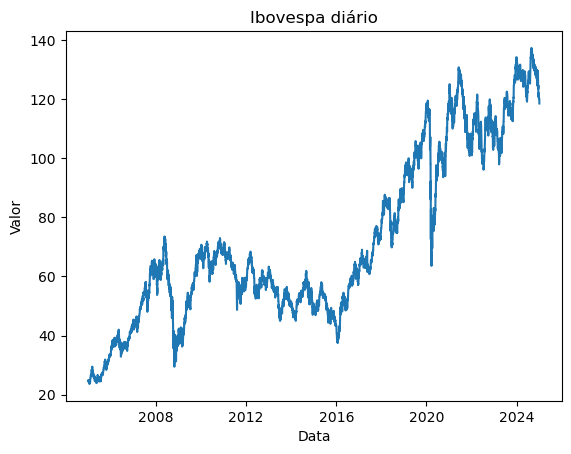

In [27]:
plt.plot(df1.index, df1["y"])
plt.xlabel('Data')
plt.ylabel('Valor')
plt.title('Ibovespa diário')
plt.show()

In [28]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose the time series
resultados = seasonal_decompose(df1['y'], model='additive', period=1)


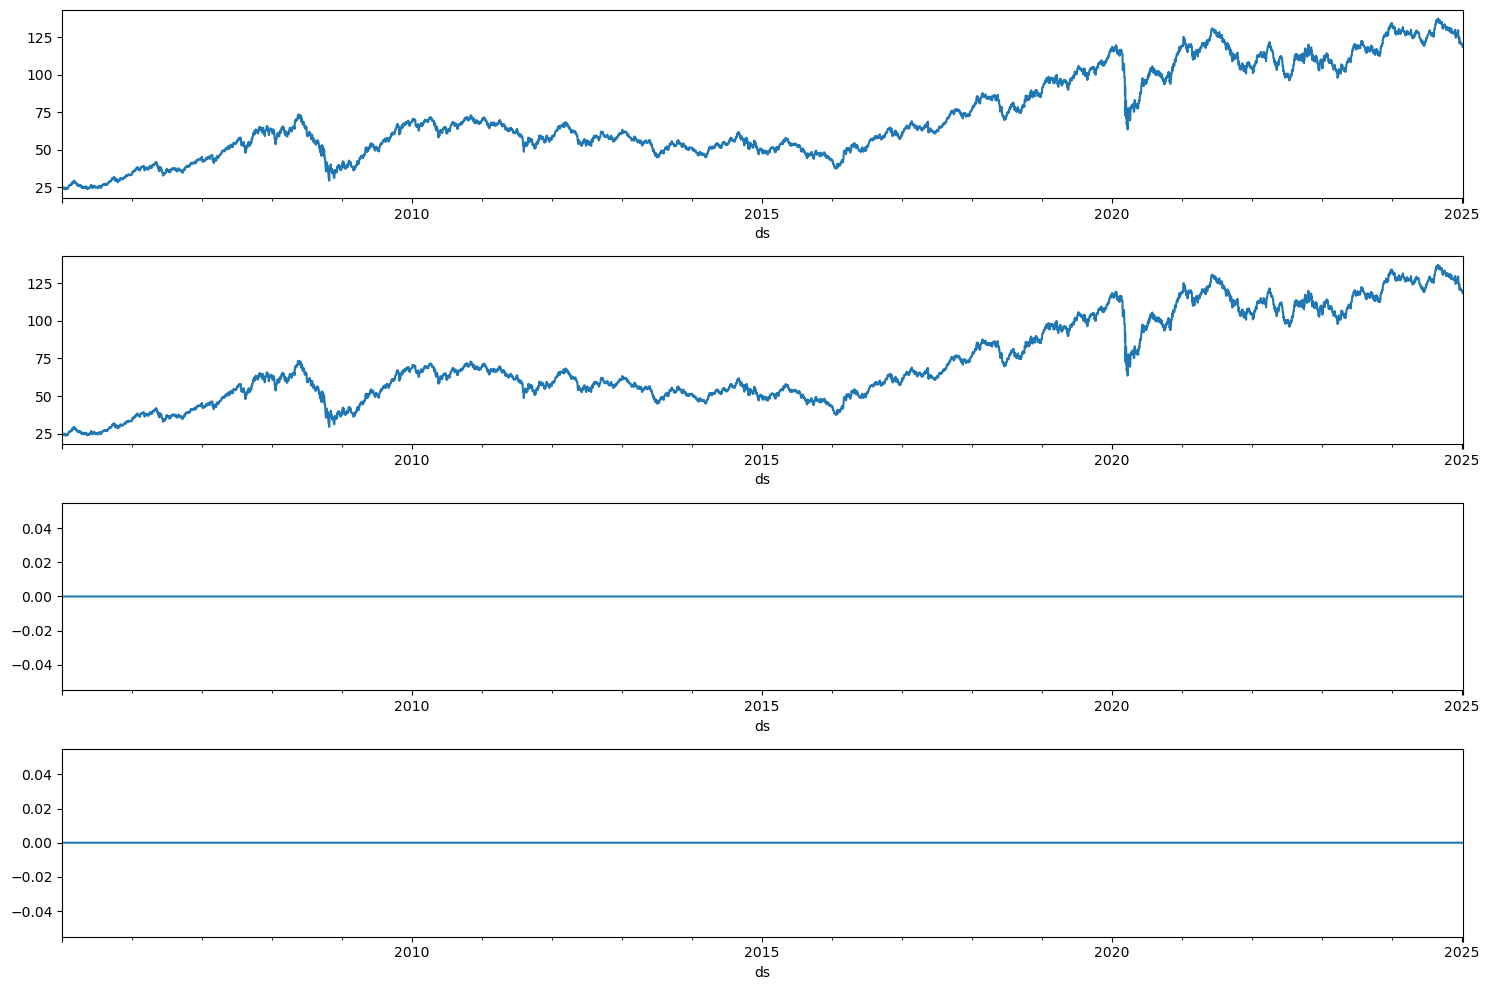

In [29]:
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize = (15,10))

# mostrando a série do data frame
resultados.observed.plot(ax=ax1)
# mostrando a tendência dos dados
resultados.trend.plot(ax=ax2)
# mostrando a sazonalidade - constante e recorrente
resultados.seasonal.plot(ax=ax3)
# mostrando os resíduos
resultados.resid.plot(ax=ax4)

plt.tight_layout()

In [30]:
from statsmodels.tsa.stattools import adfuller

In [31]:
X = df1.y.values

In [32]:
result = adfuller(X)

# como o teste estatístico é maior que os valores críticos e temos um p-value alto, descartamos a hipótese de série estacionária

print("Teste ADF")
print(f"Teste Estatístico: {result[0]}")
print(f"P-Value: {result[1]}")
print("Valores críticos:")

for key, value in result[4].items():
  print(f"\t{key}: {value}")

Teste ADF
Teste Estatístico: -1.4581585591306818
P-Value: 0.5540989239281974
Valores críticos:
	1%: -3.4312474625349556
	5%: -2.8619366088117606
	10%: -2.5669811106290608


In [33]:
df1.shape

(7305, 2)

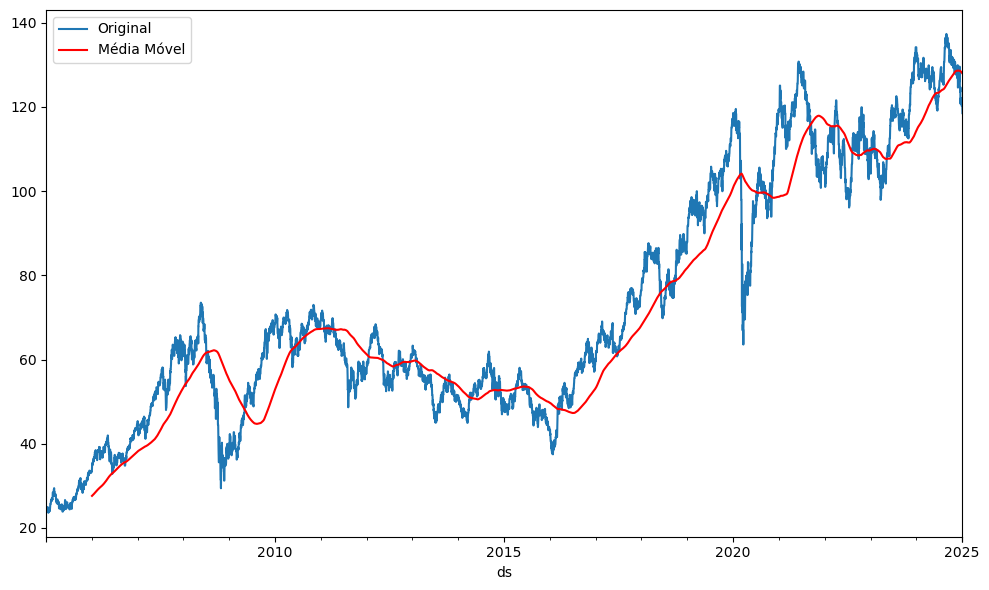

In [34]:
# Calcular média móvel com janela menor
ma = df1['y'].rolling(window=365).mean()

# Criar o gráfico
f, ax = plt.subplots(figsize=(10,6))
df1['y'].plot(ax=ax, label='Original')
ma.plot(ax=ax, color='r', label='Média Móvel')
plt.legend()
plt.tight_layout()




In [35]:
df1 = df1.reset_index().rename(columns={'index': 'ds'})

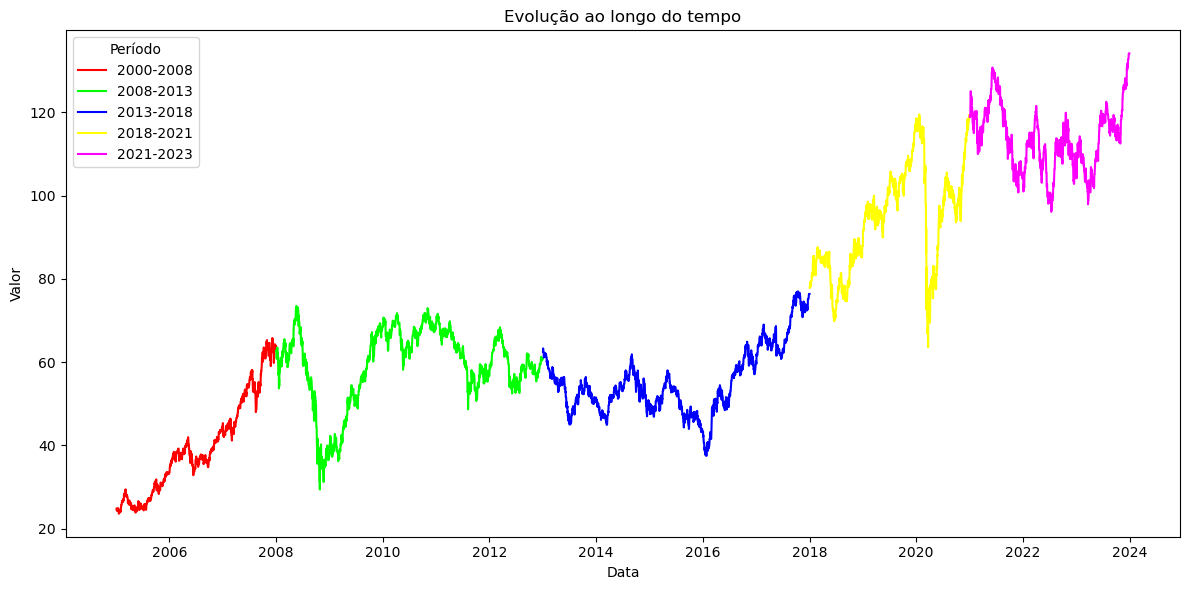

In [36]:

plt.figure(figsize=(12, 6))

# Definir as datas de corte
cut_dates = [
    datetime(2000, 1, 1),
    datetime(2008, 1, 1),
    datetime(2013, 1, 1),
    datetime(2018, 1, 1),
    datetime(2021, 1, 1),
    datetime(2023, 12, 31)
]

# Criar uma paleta de cores
colors = sns.color_palette(["#FF0000", "#00FF00", "#0000FF", "#FFFF00", "#FF00FF"])

# Plotar cada linha
for i in range(len(cut_dates) - 1):
    mask = (df1['ds'] > cut_dates[i]) & (df1['ds'] <= cut_dates[i+1])
    sns.lineplot(
        data=df1[mask],
        x='ds',
        y='y',
        color=colors[i],
        label=f'{cut_dates[i].year}-{cut_dates[i+1].year}'
    )

# Configurar o gráfico
plt.title('Evolução ao longo do tempo')
plt.xlabel('Data')
plt.ylabel('Valor')
plt.legend(title='Período')

# Ajustar o layout e mostrar o gráfico
plt.tight_layout()
plt.show()


In [38]:
def split_train_test(df, start_date, test_days=123):
    # Filtra o DataFrame para o período desejado
    df_period = df[df['ds'] >= start_date]
    
    # Separa os últimos 123 dias para teste
    split_date = df_period['ds'].max() - pd.Timedelta(days=test_days)
    
    df_train = df_period[df_period['ds'] <= split_date]
    df_test = df_period[df_period['ds'] > split_date]
    
    return df_train, df_test


In [39]:
start_dates = [
    pd.Timestamp('2000-01-01'),  # Desde o início da série histórica
    pd.Timestamp('2008-01-01'),  # Últimos 15 anos
    pd.Timestamp('2013-01-01'),  # Últimos 10 anos
    pd.Timestamp('2018-01-01'),  # Últimos 5 anos
    pd.Timestamp('2021-01-01')   # Últimos 3 anos
]


In [40]:
dfs = [split_train_test(df1, start_date) for start_date in start_dates]

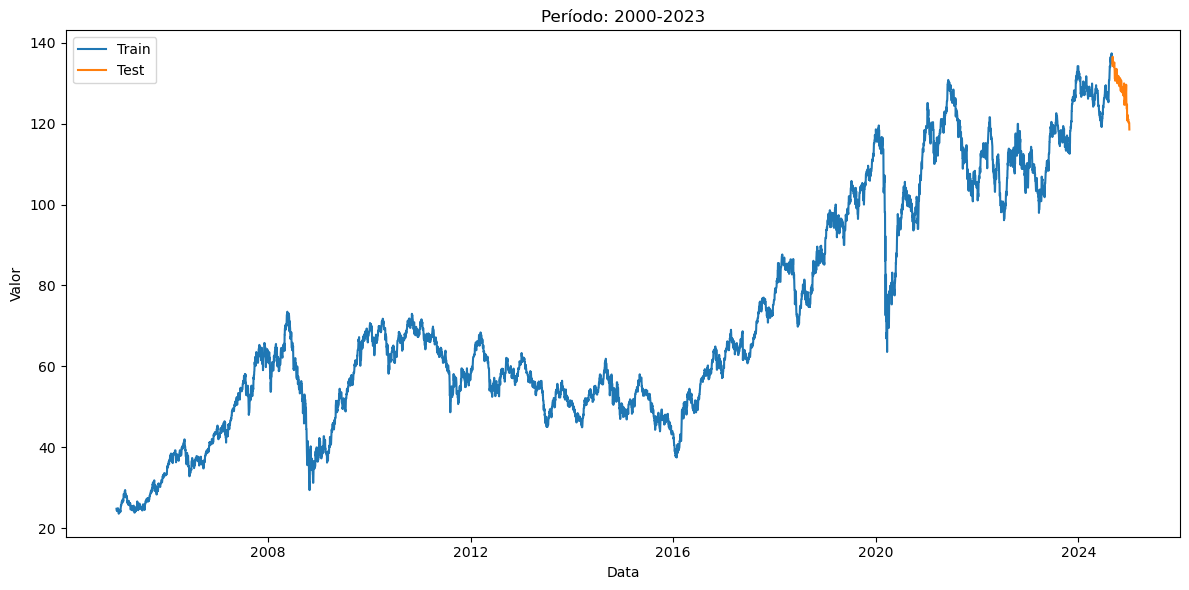

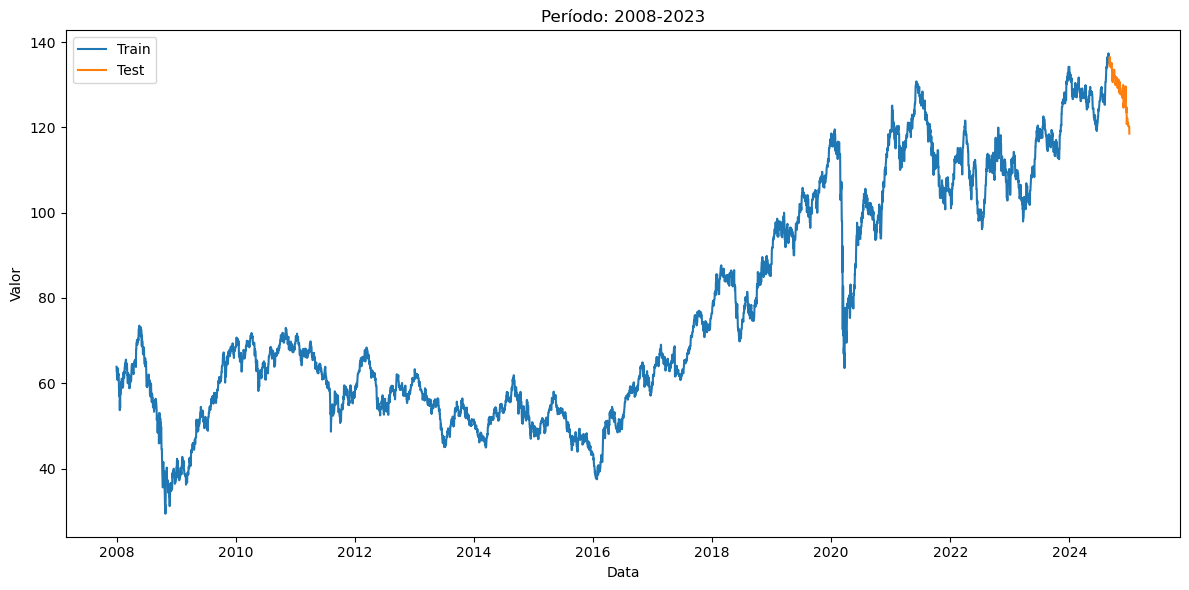

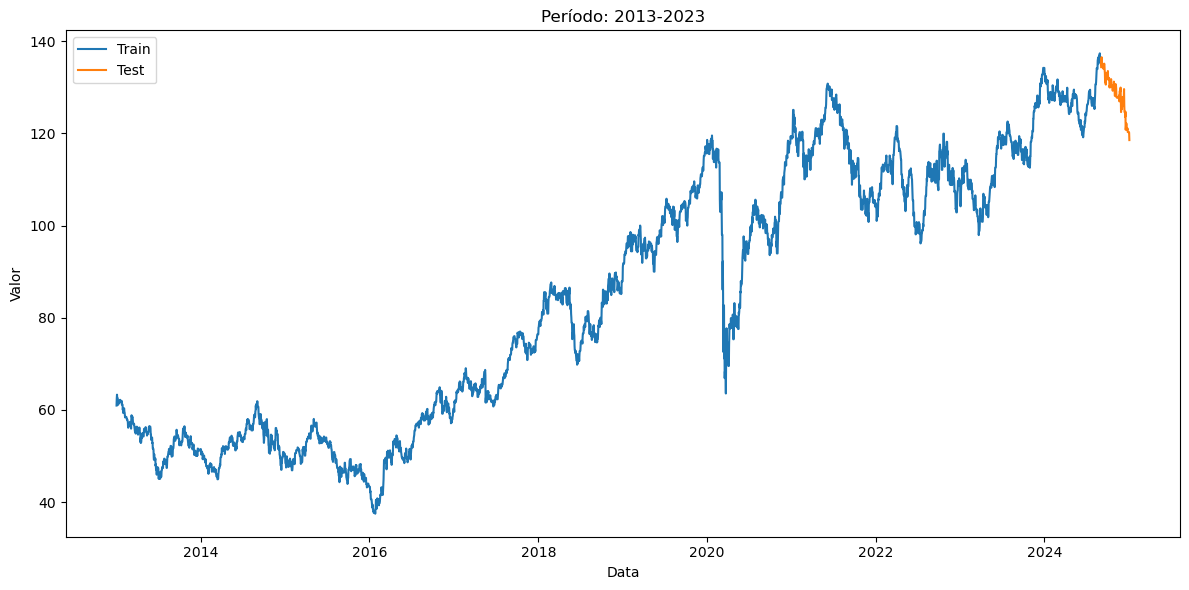

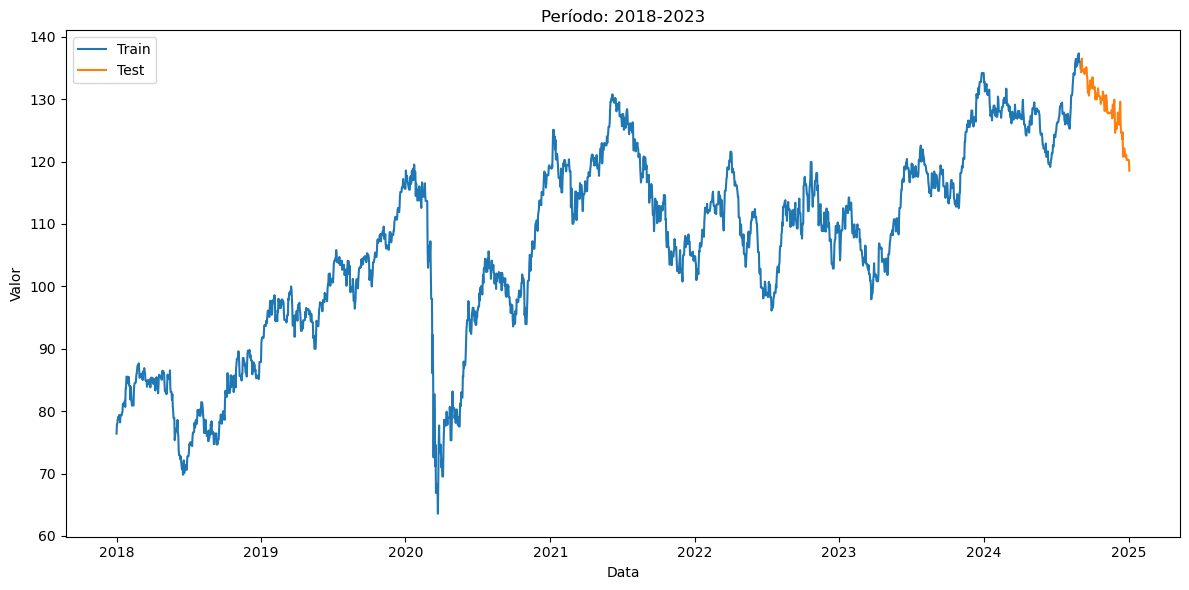

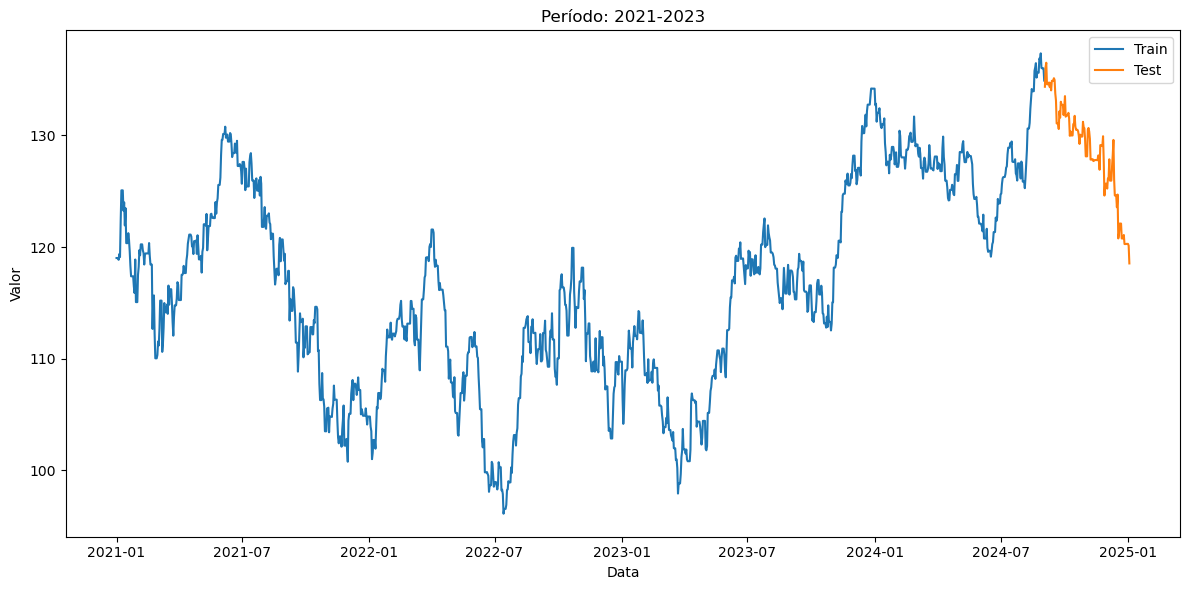

In [41]:
for i, (df_train, df_test) in enumerate(dfs):
    fig, ax = plt.subplots(figsize=(12, 6))
    
    sns.lineplot(data=df_train, x='ds', y='y', label='Train', ax=ax)
    sns.lineplot(data=df_test, x='ds', y='y', label='Test', ax=ax)
    
    ax.set_title(f'Período: {start_dates[i].year}-2023')
    ax.set_xlabel('Data')
    ax.set_ylabel('Valor')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [42]:
# Verificar o DataFrame df1
print("Informações do DataFrame:")
print(df1.info())
print("\nPrimeiras linhas do DataFrame:")
print(df1.head())

# Verificar a série da média móvel
print("\nInformações da média móvel:")
print(ma.head())
print("\nVerificar valores nulos na média móvel:")
print(ma.isnull().sum())


Informações do DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7305 entries, 0 to 7304
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   ds         7305 non-null   datetime64[ns]
 1   y          7305 non-null   float64       
 2   unique_id  7305 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 171.3+ KB
None

Primeiras linhas do DataFrame:
          ds       y unique_id
0 2005-01-04  24.848  ibovespa
1 2005-01-05  24.692  ibovespa
2 2005-01-06  24.367  ibovespa
3 2005-01-07  24.747  ibovespa
4 2005-01-08  24.747  ibovespa

Informações da média móvel:
ds
2005-01-04   NaN
2005-01-05   NaN
2005-01-06   NaN
2005-01-07   NaN
2005-01-08   NaN
Name: y, dtype: float64

Verificar valores nulos na média móvel:
364
